# **Problem Statement :**

**Objective**:
To develop and rigorously evaluate a robust classification model using only the provided dataset, with the goal of accurately predicting activity labels. The evaluation will be performed using 5-fold cross-validation to ensure generalizability.

**Dataset Description**:
The PIRvision dataset comprises occupancy detection data captured via a synchronized Low-Energy Electronically-Chopped Passive Infrared (PIR) sensor node, deployed in both residential and office environments. Each data sample represents a 4-second window of human activity recorded within the sensor’s Field-of-View (FoV).

**Each observation includes**:

55 PIR sensor readings recorded over a 4-second interval, forming a time series sequence for temporal analysis.

Ambient temperature, date, and time of measurement.

Measurements are recorded every 16 seconds and span two consecutive days.

**Activity Labels**:

Label 0: No human present within the FoV.

Label 1: Human is moving within the FoV.

Label 3: Human is present (but stationary) within the FoV.

The goal is to leverage the temporal structure of the PIR sensor data, along with the contextual metadata, to classify the activity labels with high accuracy.

## Libraries/Modules required

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import display
import torch
from torch.utils.data import TensorDataset, DataLoader
#import torch.nn as nn
#import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Concatenate  # to concatenate the meta features with the PIR features processed by the CNN-BILSTM model
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, LSTM, Dropout, Dense   # to define the CNN-BILSTM Model
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

#from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler   # to Oversample the training dataset each fold to have equal distribution of labels


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

np.random.seed(12)
torch.manual_seed(12)
torch.cuda.manual_seed(12)
torch.cuda.manual_seed_all(12)
tf.random.set_seed(12)

## Loading dataset

In [5]:
#We first read the 2 data files
df1 = pd.read_csv('pirvision_office_dataset1.csv')
df2 = pd.read_csv('pirvision_office_dataset2.csv')

In [6]:
#We now merge these 2 dataframes
df = pd.concat([df1, df2], ignore_index=True)

#We print the shapes of all datafmrames
print(df1.shape, df2.shape, df.shape)

(7651, 59) (7651, 59) (15302, 59)


# **Exploratory Data Analysis & Data Pre-Processing**

# Primary EDA

Here, we try to find insights from original dataset as provided

We explore things such as 
1. Class Label Distributions
2. Correlation of the various sensor PIR values with each other
3. Correlation of meta feature - temperature with labels
4. Range of values taken by PIR sensors

First few rows of the dataset:


,Date,Time,Label,Temperature_F,PIR_1,PIR_2,PIR_3,PIR_4,PIR_5,PIR_6,PIR_7,PIR_8,PIR_9,PIR_10,PIR_11,PIR_12,PIR_13,PIR_14,PIR_15,PIR_16,PIR_17,PIR_18,PIR_19,PIR_20,PIR_21,PIR_22,PIR_23,PIR_24,PIR_25,PIR_26,PIR_27,PIR_28,PIR_29,PIR_30,PIR_31,PIR_32,PIR_33,PIR_34,PIR_35,PIR_36,PIR_37,PIR_38,PIR_39,PIR_40,PIR_41,PIR_42,PIR_43,PIR_44,PIR_45,PIR_46,PIR_47,PIR_48,PIR_49,PIR_50,PIR_51,PIR_52,PIR_53,PIR_54,PIR_55
0,2024-08-08,19:19:56,0,86,10269,10721,11156,11170,10931,10671,10395,10133,9885,9705,9538,9418,9469,9599,9817,9910,9890,10075,10231,10247,10271,10229,10272,10354,10449,10451,10419,10409,10336,10306,10356,10461,10456,10460,10467,10422,10303,9877,9308,9061,9299,9748,10209,10615,10975,11178,11197,11161,11096,10957,10839,10735,10590,10411,10329
1,2024-08-08,19:20:12,1,86,10364,10907,11299,11238,10867,10535,10173,9950,9856,9795,9714,9702,9792,9789,9915,9900,9944,9964,9971,10059,10161,10234,10285,10309,10384,10464,10450,10427,10366,10361,10452,10502,10444,10337,10250,10313,10211,9718,9236,9193,9609,10022,10431,10798,11055,11122,11145,11136,11108,11041,10824,10645,10493,10398,10357
2,2024-08-08,19:20:28,0,86,10329,10793,11197,11242,11052,10658,10288,9988,9819,9711,9659,9626,9726,9752,9835,9942,9925,9965,10110,10174,10140,10235,10303,10365,10366,10379,10375,10287,10310,10345,10373,10328,10387,10415,10491,10421,10432,9964,9368,9135,9287,9643,10184,10663,11016,11168,11204,11162,11109,11007,10867,10700,10533,10427,10265
3,2024-08-08,19:20:44,0,86,10169,10425,10822,11133,11136,10834,10520,10228,9986,9848,9643,9562,9591,9618,9718,9849,9857,10026,10150,10198,10261,10351,10425,10469,10374,10344,10303,10293,10294,10333,10353,10345,10354,10362,10375,10369,10319,10115,9603,9182,9125,9560,10161,10560,10883,11116,11273,11186,10984,10910,10807,10714,10651,10562,10463
4,2024-08-08,19:21:00,0,86,10320,10667,11104,11234,11129,10814,10453,10040,9733,9630,9578,9476,9596,9748,9755,9823,10004,10048,10202,10234,10255,10282,10298,10319,10315,10270,10334,10400,10428,10514,10529,10453,10374,10303,10298,10238,10246,9918,9399,9198,9422,9848,10225,10615,10860,11006,11257,11370,11173,10924,10816,10754,10588,10428,10407


Dataset Overview:
Number of samples: 15302
Number of features: 59


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15302 entries, 0 to 15301
Data columns (total 59 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           15302 non-null  object
 1   Time           15302 non-null  object
 2   Label          15302 non-null  int64 
 3   Temperature_F  15302 non-null  int64 
 4   PIR_1          15302 non-null  int64 
 5   PIR_2          15302 non-null  int64 
 6   PIR_3          15302 non-null  int64 
 7   PIR_4          15302 non-null  int64 
 8   PIR_5          15302 non-null  int64 
 9   PIR_6          15302 non-null  int64 
 10  PIR_7          15302 non-null  int64 
 11  PIR_8          15302 non-null  int64 
 12  PIR_9          15302 non-null  int64 
 13  PIR_10         15302 non-null  int64 
 14  PIR_11         15302 non-null  int64 
 15  PIR_12         15302 non-null  int64 
 16  PIR_13         15302 non-null  int64 
 17  P

C:\Users\Admin\AppData\Local\Temp\ipykernel_880\1847715028.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df, palette='viridis', legend = False)


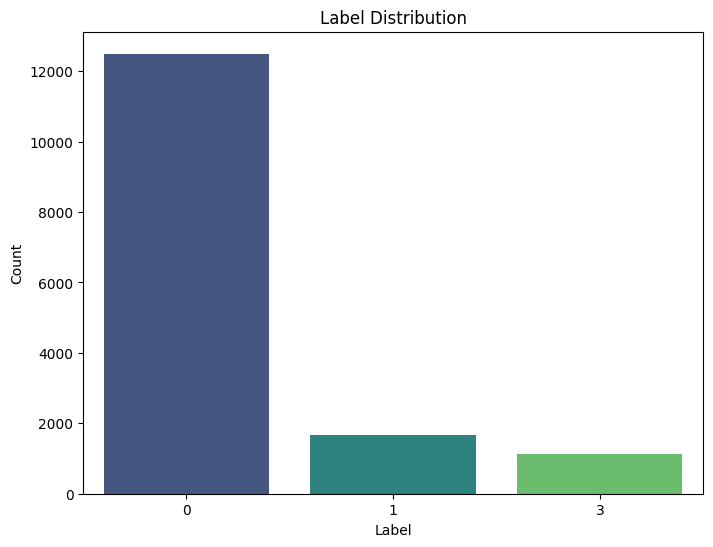


Class Distribution:
Label 0: 12494 samples (81.65%)
Label 1: 1666 samples (10.89%)
Label 3: 1142 samples (7.46%)


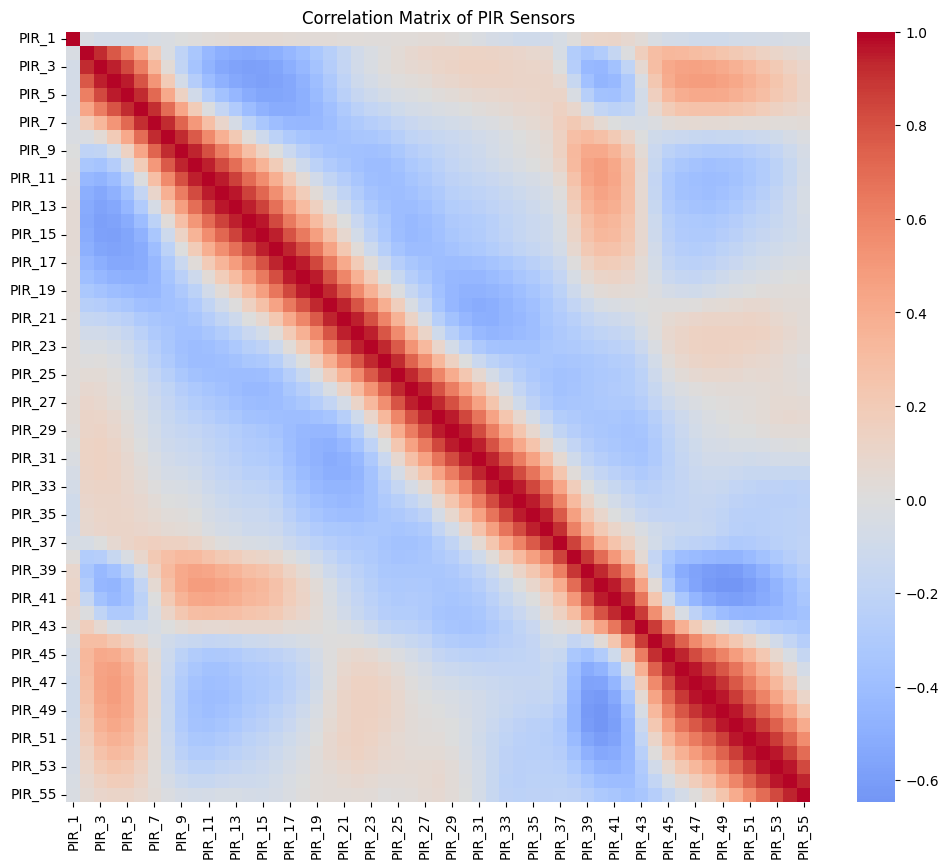


Pearson Correlation matrix between Temperature and Label:



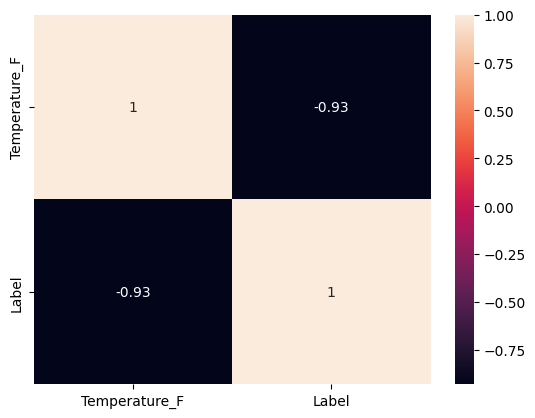

In [ ]:
# Primary anlysis based on original dataset

def Data_Analysis(df):
    # Display the first few rows of the dataset
    print("First few rows of the dataset:")
    display(df.head())
    # Dataset overview
    print("Dataset Overview:")
    print(f"Number of samples: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")

    print("\n")
    print(df.info())

    # Label distribution visualization
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Label', data=df, palette='viridis', legend = False)
    plt.title('Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

    # Display class distribution details
    print("\nClass Distribution:")
    label_counts = df['Label'].value_counts().sort_index()
    for label, count in label_counts.items():
        print(f"Label {label}: {count} samples ({(count / len(df)) * 100:.2f}%)")

    # Correlation matrix for PIR sensors
    pir_columns = [col for col in df.columns if col.startswith('PIR_')]

    if pir_columns:
        plt.figure(figsize=(12, 10))
        correlation_matrix = df[pir_columns].corr()
        sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix of PIR Sensors')
        plt.show()

    #Correlation matrix for Temperature and Label
    print('\nPearson Correlation matrix between Temperature and Label:\n')
    corr = df[['Temperature_F', 'Label']].corr(method='pearson')
    sns.heatmap(corr, annot=True)
    plt.show()

    # Range comparison of the values taken by the 55 PIR sensors
    pir_stats = df[pir_columns].agg(['min', 'max']).T  # Calculate min and max for each sensor
    pir_stats['range'] = pir_stats['max'] - pir_stats['min']  # Compute range

    # Plot the ranges as a horizontal bar chart
    plt.figure(figsize=(10, 8))
    plt.barh(pir_stats.index, pir_stats['range'], color='skyblue')
    plt.title("Range (Max - Min) of PIR Sensor Values")
    plt.xlabel("Range (Max - Min)")
    plt.ylabel("PIR Sensor")
    plt.tight_layout()
    plt.show()

# Load and analyze the dataset
Data_Analysis(df)

From this, we understand the following:

1. The Dataset contains 59 features, 55 PIR values and 4 meta features - Date, Time, Label, and Temperature
2. No NULL values are present in the Dataset
3. The data is highly skewed towards Label 0 making it necessary to adopt algorithms to mitigate class imbalance - weighted loss/ oversampling
4. There is high inverse correlation between "Temperature_F" feature and the label of the data point , as seen from the pearson correlation matrix.
5. The adjacent PIR values are highly correlated (intuitive) as they are measured one after the another. This fact can be utilised for feature dimension reduction using NN models like 1D CNN to improve computational complexity.
6. The MAX and MIN value of the PIR readings suggest a wide range in the values indicating towards normalising the values for faster training and convergence

# Feature Engineering

Since, the Date and Time have been explicitly mentioned in the dataset, it is logical to extract meaningful numbers from the given information and using it later as meta data to improve performance of the model.

Pre-modelling correlation annalysis of the meta data with the Label has been done later to directly check for potential relationship amongst them.

In [8]:
# Feature Engineering - PART 1

# Ensure 'Date' and 'Time' are parsed correctly
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Extract temporal features
df['Hour'] = df['Datetime'].dt.hour
df['Minute'] = df['Datetime'].dt.minute
df['DayOfWeek'] = df['Datetime'].dt.dayofweek
df['Month'] = df['Datetime'].dt.month

df = df.drop(columns=['Date', 'Time', 'Datetime'])

#Question - Do we consider cyclic nature of minute, hour??

meta_features = ['Hour', 'Minute', 'DayOfWeek', 'Month', 'Temperature_F']

### Generating PIR Values 

Secondly, after experimenting with a few other modes and conducting ablation studies, we realised that a time-series model might benefit from having longer and more meaningful sequences. After careful experimentation, we foudn that adding an extra PIR value in between 2 PIR values boosts the accuracy of the model.

In [9]:
# Feature Engineering - PART 2

# Interpolating pairwise PIR sensor values to generate more features per time stamp
x = np.zeros((df.shape[0], 55+54+6))

for i in range(df.shape[0]):
  for j in range (0, 2):
    x[i,j] = df.iloc[i,j]
  for j in range(2, 55+54+2):
    if(j%2 == 0):
      x[i,j] = df.iloc[i,j//2]
    else:
      x[i,j] = (df.iloc[i,j//2] + df.iloc[i,j//2+1])/2
  for j in range(55+54+2, 55+54+6):
    x[i, j] = df.iloc[i, j-54]

x_df = pd.DataFrame(x)

x_df.columns = ['Label', 'Temperature_F'] + [f'PIR_{i}' for i in range(109)] + ['Hour', 'Minute', 'DayOfWeek', 'Month']

df = x_df

# Secondary EDA

Now that we have visualized the time-series features, let us understand the relation between the meta features and the label. We do it with the help of countpolt

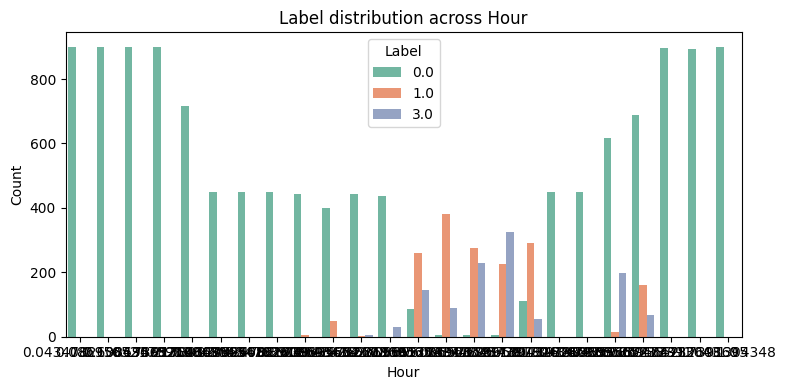

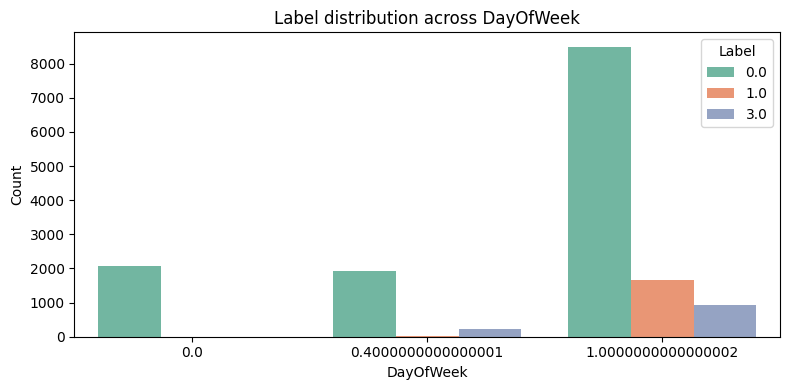

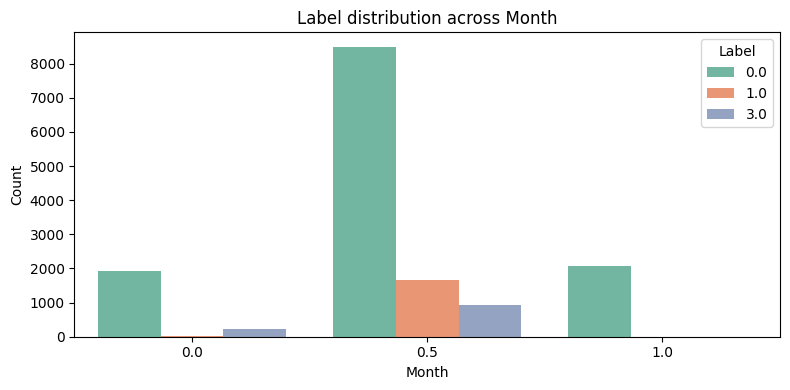

In [21]:

for feature in ['Hour', 'DayOfWeek', 'Month']:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=feature, hue="Label", data=df, palette='Set2')
    plt.title(f'Label distribution across {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Label')
    plt.tight_layout()
    plt.show()



# Data Normalisation/Standardisation

Here, we normalize and standardize our data. We chose to standardise the PIR values and normalize the meta data features. We made this subtle choice as we felt the PIR values follow some distribution and hence should be standardised, and the meta data are numerical values within fixed range - which should be normalized.

In [11]:
# Data Preprocessing - Data standardisation
scaler = StandardScaler()
min_max_scalar = MinMaxScaler()

numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
numeric_cols = numeric_cols.drop("Label")  # Exclude the Label column

# Question - saw somewhere that for meta columsn(fixed range values) MInMax scaler is better than StandardScaler?

PIR_columns = [f'PIR_{i}' for i in range(109)]
Meta_columns = ['Temperature_F', 'Hour', 'Minute', 'DayOfWeek', 'Month']

df[PIR_columns] = scaler.fit_transform(df[PIR_columns])
df[Meta_columns] = min_max_scalar.fit_transform(df[Meta_columns])

In [12]:
df.head()   #Final preprocessed dataset

,Label,Temperature_F,PIR_0,PIR_1,PIR_2,PIR_3,PIR_4,PIR_5,PIR_6,PIR_7,PIR_8,PIR_9,PIR_10,PIR_11,PIR_12,PIR_13,PIR_14,PIR_15,PIR_16,PIR_17,PIR_18,PIR_19,PIR_20,PIR_21,PIR_22,PIR_23,PIR_24,PIR_25,PIR_26,PIR_27,PIR_28,PIR_29,PIR_30,PIR_31,PIR_32,PIR_33,PIR_34,PIR_35,PIR_36,PIR_37,PIR_38,PIR_39,PIR_40,PIR_41,PIR_42,PIR_43,PIR_44,PIR_45,PIR_46,PIR_47,PIR_48,PIR_49,PIR_50,PIR_51,PIR_52,PIR_53,PIR_54,PIR_55,PIR_56,PIR_57,PIR_58,PIR_59,PIR_60,PIR_61,PIR_62,PIR_63,PIR_64,PIR_65,PIR_66,PIR_67,PIR_68,PIR_69,PIR_70,PIR_71,PIR_72,PIR_73,PIR_74,PIR_75,PIR_76,PIR_77,PIR_78,PIR_79,PIR_80,PIR_81,PIR_82,PIR_83,PIR_84,PIR_85,PIR_86,PIR_87,PIR_88,PIR_89,PIR_90,PIR_91,PIR_92,PIR_93,PIR_94,PIR_95,PIR_96,PIR_97,PIR_98,PIR_99,PIR_100,PIR_101,PIR_102,PIR_103,PIR_104,PIR_105,PIR_106,PIR_107,PIR_108,Hour,Minute,DayOfWeek,Month
0,0.0,0.966292,0.245676,-0.055874,-0.055875,-0.055944,-0.494950,-0.535025,-0.551045,-0.591841,-0.616061,-0.595164,-0.558023,-0.411659,-0.230890,-0.040599,0.165129,0.314171,0.450680,0.498168,0.525723,0.528330,0.515734,0.447967,0.370196,0.279563,0.184010,0.194594,0.201863,0.243975,0.280221,0.381752,0.477645,0.453421,0.416393,0.281833,0.137928,0.199226,0.257101,0.307502,0.352263,0.280735,0.197236,0.140089,0.078255,-0.035004,-0.148685,-0.162059,-0.170861,-0.131657,-0.087877,-0.019885,0.050418,0.032361,0.013493,-0.033058,-0.077806,-0.092583,-0.103976,-0.173862,-0.238827,-0.266700,-0.288882,-0.233162,-0.170143,-0.050141,0.069416,0.075027,0.078371,0.093931,0.107238,0.127637,0.145402,0.116187,0.082729,0.108872,0.129407,0.287074,0.399382,0.472744,0.512783,0.502623,0.475682,0.477421,0.467011,0.412986,0.333056,0.177566,-0.012290,-0.189309,-0.350064,-0.398756,-0.426881,-0.457676,-0.472273,-0.531099,-0.577291,-0.599922,-0.614463,-0.599804,-0.574078,-0.578531,-0.572173,-0.534485,-0.483428,-0.424869,-0.355541,-0.338631,-0.314113,-0.347892,-0.376149,0.826087,0.322034,0.4,0.0
1,1.0,0.966292,0.245676,-0.055852,-0.055853,-0.055878,-0.180633,-0.266177,-0.333270,-0.429731,-0.513508,-0.591975,-0.663652,-0.589812,-0.484048,-0.392987,-0.277654,-0.099009,0.084387,0.286769,0.470167,0.586064,0.679292,0.689126,0.679981,0.685867,0.676146,0.731050,0.773828,0.707510,0.621484,0.646532,0.658225,0.535910,0.397845,0.323367,0.238492,0.144941,0.045904,-0.056683,-0.161902,-0.176954,-0.186373,-0.169357,-0.146818,-0.144674,-0.138325,-0.143058,-0.143695,-0.165733,-0.182316,-0.138881,-0.089082,-0.023935,0.040904,0.013455,-0.013779,-0.041444,-0.067306,-0.124524,-0.178165,-0.179000,-0.175699,-0.074587,0.029915,0.093617,0.153468,0.104805,0.054383,-0.042301,-0.137586,-0.217401,-0.293455,-0.223551,-0.145031,-0.104631,-0.059855,0.043706,0.127043,0.285027,0.406865,0.546212,0.658589,0.799215,0.930333,0.896097,0.821685,0.664868,0.440365,0.232227,0.014222,-0.144127,-0.282181,-0.436510,-0.565744,-0.619964,-0.660100,-0.662097,-0.654840,-0.610573,-0.554029,-0.495710,-0.425187,-0.472090,-0.510887,-0.524366,-0.529183,-0.526364,-0.513220,-0.464623,-0.404123,0.826087,0.338983,0.4,0.0
2,0.0,0.966292,0.245676,-0.055860,-0.055861,-0.055913,-0.373279,-0.442685,-0.488606,-0.505024,-0.507475,-0.441310,-0.358319,-0.315456,-0.255089,-0.158718,-0.048284,0.057081,0.160448,0.287766,0.399285,0.471542,0.526638,0.563107,0.583173,0.570159,0.544447,0.605553,0.656956,0.614442,0.555027,0.538965,0.510813,0.500290,0.475745,0.345078,0.203108,0.127798,0.047807,0.080746,0.112979,0.082539,0.048281,-0.071746,-0.189786,-0.165564,-0.136253,-0.123001,-0.106080,-0.086932,-0.064792,-0.097773,-0.127713,-0.135444,-0.138317,-0.155684,-0.168683,-0.265832,-0.352515,-0.325986,-0.291400,-0.253287,-0.208625,-0.174353,-0.134716,-0.171863,-0.203240,-0.132395,-0.059561,-0.021109,0.017668,0.106326,0.193939,0.140156,0.080640,0.244834,0.394786,0.496506,0.548397,0.592200,0.601048,0.599971,0.578221,0.522559,0.449076,0.316198,0.145808,0.049845,-0.063265,-0.165370,-0.254513,-0.312589,-0.352722,-0.430337,-0.488964,-0.533568,-0.566144,-0.593462,-0.612848,-0.588206,-0.552358,-0.524180,-0.484681,-0.463952,-0.432172,-0.431502,-0.423068,-0.43

In [13]:
PIR_data = df[PIR_columns + ['Label']]

In [14]:
Meta_data = df[Meta_columns]

In [15]:
Meta_data.head(10)

,Temperature_F,Hour,Minute,DayOfWeek,Month
0,0.966292,0.826087,0.322034,0.4,0.0
1,0.966292,0.826087,0.338983,0.4,0.0
2,0.966292,0.826087,0.338983,0.4,0.0
3,0.966292,0.826087,0.338983,0.4,0.0
4,0.966292,0.826087,0.355932,0.4,0.0
5,0.966292,0.826087,0.355932,0.4,0.0
6,0.966292,0.826087,0.355932,0.4,0.0
7,0.966292,0.826087,0.355932,0.4,0.0
8,0.966292,0.826087,0.372881,0.4,0.0
9,0.966292,0.826087,0.372881,0.4,0.0


In [16]:
PIR_data.head(10)

,PIR_0,PIR_1,PIR_2,PIR_3,PIR_4,PIR_5,PIR_6,PIR_7,PIR_8,PIR_9,PIR_10,PIR_11,PIR_12,PIR_13,PIR_14,PIR_15,PIR_16,PIR_17,PIR_18,PIR_19,PIR_20,PIR_21,PIR_22,PIR_23,PIR_24,PIR_25,PIR_26,PIR_27,PIR_28,PIR_29,PIR_30,PIR_31,PIR_32,PIR_33,PIR_34,PIR_35,PIR_36,PIR_37,PIR_38,PIR_39,PIR_40,PIR_41,PIR_42,PIR_43,PIR_44,PIR_45,PIR_46,PIR_47,PIR_48,PIR_49,PIR_50,PIR_51,PIR_52,PIR_53,PIR_54,PIR_55,PIR_56,PIR_57,PIR_58,PIR_59,PIR_60,PIR_61,PIR_62,PIR_63,PIR_64,PIR_65,PIR_66,PIR_67,PIR_68,PIR_69,PIR_70,PIR_71,PIR_72,PIR_73,PIR_74,PIR_75,PIR_76,PIR_77,PIR_78,PIR_79,PIR_80,PIR_81,PIR_82,PIR_83,PIR_84,PIR_85,PIR_86,PIR_87,PIR_88,PIR_89,PIR_90,PIR_91,PIR_92,PIR_93,PIR_94,PIR_95,PIR_96,PIR_97,PIR_98,PIR_99,PIR_100,PIR_101,PIR_102,PIR_103,PIR_104,PIR_105,PIR_106,PIR_107,PIR_108,Label
0,0.245676,-0.055874,-0.055875,-0.055944,-0.494950,-0.535025,-0.551045,-0.591841,-0.616061,-0.595164,-0.558023,-0.411659,-0.230890,-0.040599,0.165129,0.314171,0.450680,0.498168,0.525723,0.528330,0.515734,0.447967,0.370196,0.279563,0.184010,0.194594,0.201863,0.243975,0.280221,0.381752,0.477645,0.453421,0.416393,0.281833,0.137928,0.199226,0.257101,0.307502,0.352263,0.280735,0.197236,0.140089,0.078255,-0.035004,-0.148685,-0.162059,-0.170861,-0.131657,-0.087877,-0.019885,0.050418,0.032361,0.013493,-0.033058,-0.077806,-0.092583,-0.103976,-0.173862,-0.238827,-0.266700,-0.288882,-0.233162,-0.170143,-0.050141,0.069416,0.075027,0.078371,0.093931,0.107238,0.127637,0.145402,0.116187,0.082729,0.108872,0.129407,0.287074,0.399382,0.472744,0.512783,0.502623,0.475682,0.477421,0.467011,0.412986,0.333056,0.177566,-0.012290,-0.189309,-0.350064,-0.398756,-0.426881,-0.457676,-0.472273,-0.531099,-0.577291,-0.599922,-0.614463,-0.599804,-0.574078,-0.578531,-0.572173,-0.534485,-0.483428,-0.424869,-0.355541,-0.338631,-0.314113,-0.347892,-0.376149,0.0
1,0.245676,-0.055852,-0.055853,-0.055878,-0.180633,-0.266177,-0.333270,-0.429731,-0.513508,-0.591975,-0.663652,-0.589812,-0.484048,-0.392987,-0.277654,-0.099009,0.084387,0.286769,0.470167,0.586064,0.679292,0.689126,0.679981,0.685867,0.676146,0.731050,0.773828,0.707510,0.621484,0.646532,0.658225,0.535910,0.397845,0.323367,0.238492,0.144941,0.045904,-0.056683,-0.161902,-0.176954,-0.186373,-0.169357,-0.146818,-0.144674,-0.138325,-0.143058,-0.143695,-0.165733,-0.182316,-0.138881,-0.089082,-0.023935,0.040904,0.013455,-0.013779,-0.041444,-0.067306,-0.124524,-0.178165,-0.179000,-0.175699,-0.074587,0.029915,0.093617,0.153468,0.104805,0.054383,-0.042301,-0.137586,-0.217401,-0.293455,-0.223551,-0.145031,-0.104631,-0.059855,0.043706,0.127043,0.285027,0.406865,0.546212,0.658589,0.799215,0.930333,0.896097,0.821685,0.664868,0.440365,0.232227,0.014222,-0.144127,-0.282181,-0.436510,-0.565744,-0.619964,-0.660100,-0.662097,-0.654840,-0.610573,-0.554029,-0.495710,-0.425187,-0.472090,-0.510887,-0.524366,-0.529183,-0.526364,-0.513220,-0.464623,-0.404123,1.0
2,0.245676,-0.055860,-0.055861,-0.055913,-0.373279,-0.442685,-0.488606,-0.505024,-0.507475,-0.441310,-0.358319,-0.315456,-0.255089,-0.158718,-0.048284,0.057081,0.160448,0.287766,0.399285,0.471542,0.526638,0.563107,0.583173,0.570159,0.544447,0.605553,0.656956,0.614442,0.555027,0.538965,0.510813,0.500290,0.475745,0.345078,0.203108,0.127798,0.047807,0.080746,0.112979,0.082539,0.048281,-0.071746,-0.189786,-0.165564,-0.136253,-0.123001,-0.106080,-0.086932,-0.064792,-0.097773,-0.127713,-0.135444,-0.138317,-0.155684,-0.168683,-0.265832,-0.352515,-0.325986,-0.291400,-0.253287,-0.208625,-0.174353,-0.134716,-0.171863,-0.203240,-0.132395,-0.059561,-0.021109,0.017668,0.106326,0.193939,0.140156,0.080640,0.244834,0.394786,0.496506,0.548397,0.592200,0.601048,0.599971,0.578221,0.522559,0.449076,0.316198,0.145808,0.049845,-0.063265,-0.165370,-0.254513,-0.312589,-0.352722,-0.430337,-0.488964,-0.533568,-0.566144,-0.593462,-0.612848,-0.588206,-0.552358,-0.524180,-0.484681,-0.463952,-0.432172,-0.431502,-0.423068,-0.430992,-0.431114,-0.391401,-0.341720,0.0
3,0.245676,-0.055897,-0.055899,-0.056036,-0.995152,-1.049842,-1.059694,-0.876879,-0.67

In [17]:
X_Meta = Meta_data.values
X_Meta

array([[0.96629213, 0.82608696, 0.3220339 , 0.4       , 0.        ],
       [0.96629213, 0.82608696, 0.33898305, 0.4       , 0.        ],
       [0.96629213, 0.82608696, 0.33898305, 0.4       , 0.        ],
       ...,
       [0.98876404, 0.17391304, 0.57627119, 0.        , 1.        ],
       [0.98876404, 0.17391304, 0.59322034, 0.        , 1.        ],
       [0.98876404, 0.17391304, 0.59322034, 0.        , 1.        ]])

# **Main Model Architecture + Implementation + Cross validation**

# Model Architecture - **CNN BILSTM** using **Time-Series** (PIR readings) + **Meta** (Time, Date, Temperature) **Data**

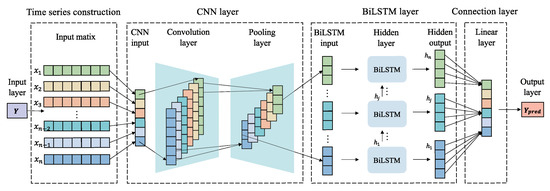

The CNN-BILSTM is a hydbrid model, as the name suggests, made of a CNN module followed by a Bidirectional LSTM, leveraging CNNs for feature extraction and BiLSTMs for temporal abstraction.

The proposed model is a **dual-input hybrid neural network using CNN-BILSTM** as the core model, designed to classify sensor time-series data while incorporating metadata for enhanced predictions.

The architecture consists of two branches: a **time-series branch** and a **metadata branch**.
1. The time-series branch processes univariate temporal data (109 timesteps) using TimeDistributed Conv1D layers for local feature extraction, followed by MaxPooling layers for dimensionality reduction. Temporal dependencies are captured using two Bidirectional LSTM layers, enabling the model to learn both past and future context.

2. The metadata branch directly processes auxiliary features such as hour, day, and temperature.

Features from both branches are concatenated using a Concatenation layer, creating a unified representation that combines temporal and contextual information. A Dropout layer regularizes the fused features before passing them to a Dense fully connected layer with softmax activation for multi-class classification.

The model is trained using the Adam optimizer with categorical cross-entropy loss and accuracy, F1 score as the evaluation metric.

 This architecture efficiently integrates heterogeneous data modalities wmaking it well-suited for sensor data interpretation alongside metadata.

![Flowchart](Flowchart.png)


In [18]:
def create_model():
    #Time series input branch
    ts_input = Input(shape=(1, 109, 1), name='ts_input')
    x = TimeDistributed(Conv1D(256, 3, activation='relu'))(ts_input)
    x = TimeDistributed(MaxPooling1D(2))(x)
    x = TimeDistributed(Conv1D(128, 3, activation='relu'))(x)
    x = TimeDistributed(MaxPooling1D(2))(x)
    x = TimeDistributed(Flatten())(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    ts_features = Bidirectional(LSTM(50))(x)

    #Metadata input branch
    meta_input = Input(shape=(5,), name='meta_input')  # 5 metadata columns

    #Concatenate features
    merged = Concatenate()([ts_features, meta_input])

    #Continue with original architecture
    x = Dropout(0.5)(merged)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs=[ts_input, meta_input], outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Training and Cross Validation

In [20]:
X = PIR_data.iloc[:, :-1].values  #first 109 columns are the PIR time series
y = PIR_data.iloc[:, -1].values   #last column is the class label


X = X.reshape((X.shape[0], 1, 109, 1))

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  #now y becomes 0, 1, 2
y_categorical = to_categorical(y_encoded)

# We set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1

#These are the arrays which will store all the accuracies and losses across folds and across epochs
f1_scores = []
accuracies = []
all_reports = []
train_loss_per_fold = []
val_loss_per_fold = []
val_acc_per_fold = []
all_histories = []
confusion_matrices = []


# This is our main cross validation loop, where we divide data into folds, train, and evaluate
for train_index, test_index in kf.split(X):
    print(f"\n--- Fold {fold_no} ---")

    ######Build CNN-LSTM Model
    model = create_model()
    model.summary()
    X_train, X_test = X[train_index], X[test_index]
    meta_train, meta_test = X_Meta[train_index], X_Meta[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

    import pickle

    with open(f'test_data_fold{fold_no}.pkl', 'wb') as f:
        pickle.dump((X_test, meta_test, y_test), f)


    ###### Resampling for class imbalance
    ros = RandomOverSampler(random_state=0)
    y_train_labels = np.argmax(y_train, axis=1)

    # Flatten time series and combine with metadata
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    combined_train = np.hstack([X_train_flat, meta_train])

    # We resample combined data
    combined_resampled, y_resampled = ros.fit_resample(combined_train, y_train_labels)

    # Split back into components
    X_resampled = combined_resampled[:, :-5].reshape(-1, 1, 109, 1)
    meta_resampled = combined_resampled[:, -5:]
    y_resampled = to_categorical(y_resampled)

    ###Trainign the model
    history = model.fit(
        [X_resampled, meta_resampled], y_resampled,
        validation_data=([X_test, meta_test], y_test),
        epochs=20,
        batch_size=32
    )

    model.save_weights(f'Trained_Model_Fold{fold_no}.weights.h5')


    all_histories.append(history.history)
    train_loss_per_fold.append(history.history['loss'])
    val_loss_per_fold.append(history.history['val_loss'][-1])
    val_acc_per_fold.append(history.history['val_accuracy'][-1])

    ### Training over, now we evaluate
    y_pred = model.predict([X_test, meta_test])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    #Computing and printing confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    # plt.figure(figsize=(6, 5))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                # xticklabels=label_encoder.classes_, 
                # yticklabels=label_encoder.classes_)
    # plt.title(f'Confusion Matrix - Fold {fold_no}')
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.show()

    confusion_matrices.append(cm)

    acc = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

    # Computing and printing accuracy and f1 score
    print("Accuracy:", acc)
    print("F1 Macro Score:", f1)
    # print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

    report = classification_report(
        y_true_classes, y_pred_classes,
        target_names=label_encoder.classes_,
        output_dict=True
    )
    all_reports.append(report)

    accuracies.append(acc)
    f1_scores.append(f1)

    fold_no += 1
    # if(fold_no == 2):
    #     break

    # y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
    # y_true_labels = label_encoder.inverse_transform(y_true_classes)

    # from sklearn.metrics import classification_report
    # print(classification_report(y_true_classes, y_pred_classes))


--- Fold 1 ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ts_input            │ (None, 1, 109, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 1, 107,    │      1,024 │ ts_input[0][0]    │
│ (TimeDistributed)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 1, 53,     │          0 │ time_distributed… │
│ (TimeDistributed)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 1, 51,     │     98,432 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 1, 25,     │          0 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 1, 3200)   │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 1, 256)    │  3,408,896 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 100)       │    122,800 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 105)       │          0 │ bidirectional_3[… │
│ (Concatenate)       │                   │            │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 105)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        318 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,631,470 (13.85 MB)

 Trainable params: 3,631,470 (13.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9430 - loss: 0.1282 - val_accuracy: 0.9781 - val_loss: 0.0620
Epoch 2/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9912 - loss: 0.0240 - val_accuracy: 0.9873 - val_loss: 0.0424
Epoch 3/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9930 - loss: 0.0190 - val_accuracy: 0.9876 - val_loss: 0.0358
Epoch 4/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9955 - loss: 0.0139 - val_accuracy: 0.9873 - val_loss: 0.0339
Epoch 5/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9958 - loss: 0.0109 - val_accuracy: 0.9938 - val_loss: 0.0269
Epoch 6/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9973 - loss: 0.0080 - val_accuracy: 0.9944 - val_loss: 0.0176
Epoch 7/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9973 - loss: 0.0079 - val_accuracy: 0.9938 - val_loss: 0.0294
Epoch 8/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9979 - loss: 0.0069 - 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ts_input            │ (None, 1, 109, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 1, 107,    │      1,024 │ ts_input[0][0]    │
│ (TimeDistributed)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, 1, 53,     │          0 │ time_distributed… │
│ (TimeDistributed)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 1, 51,     │     98,432 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, 1, 25,     │          0 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, 1, 3200)   │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 1, 256)    │  3,408,896 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 100)       │    122,800 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 105)       │          0 │ bidirectional_5[… │
│ (Concatenate)       │                   │            │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 105)       │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        318 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,631,470 (13.85 MB)

 Trainable params: 3,631,470 (13.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9451 - loss: 0.1400 - val_accuracy: 0.9811 - val_loss: 0.0547
Epoch 2/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9908 - loss: 0.0265 - val_accuracy: 0.9791 - val_loss: 0.0591
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9928 - loss: 0.0220 - val_accuracy: 0.9811 - val_loss: 0.0603
Epoch 4/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9944 - loss: 0.0183 - val_accuracy: 0.9775 - val_loss: 0.0954
Epoch 5/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9962 - loss: 0.0122 - val_accuracy: 0.9909 - val_loss: 0.0307
Epoch 6/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9965 - loss: 0.0098 - val_accuracy: 0.9909 - val_loss: 0.0330
Epoch 7/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9976 - loss: 0.0099 - val_accuracy: 0.9922 - val_loss: 0.0285
Epoch 8/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.9980 - loss: 0.0074 - 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ts_input            │ (None, 1, 109, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 1, 107,    │      1,024 │ ts_input[0][0]    │
│ (TimeDistributed)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_16 │ (None, 1, 53,     │          0 │ time_distributed… │
│ (TimeDistributed)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_17 │ (None, 1, 51,     │     98,432 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, 1, 25,     │          0 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_19 │ (None, 1, 3200)   │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 1, 256)    │  3,408,896 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 100)       │    122,800 │ bidirectional_6[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 105)       │          0 │ bidirectional_7[… │
│ (Concatenate)       │                   │            │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 105)       │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        318 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,631,470 (13.85 MB)

 Trainable params: 3,631,470 (13.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.9382 - loss: 0.1479 - val_accuracy: 0.9948 - val_loss: 0.0146
Epoch 2/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9916 - loss: 0.0262 - val_accuracy: 0.9951 - val_loss: 0.0131
Epoch 3/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9926 - loss: 0.0197 - val_accuracy: 0.9944 - val_loss: 0.0138
Epoch 4/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9938 - loss: 0.0158 - val_accuracy: 0.9961 - val_loss: 0.0111
Epoch 5/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.9946 - loss: 0.0142 - val_accuracy: 0.9961 - val_loss: 0.0113
Epoch 6/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9961 - loss: 0.0107 - val_accuracy: 0.9958 - val_loss: 0.0116
Epoch 7/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9967 - loss: 0.0093 - val_accuracy: 0.9977 - val_loss: 0.0108
Epoch 8/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9958 - loss: 0.0126 - 

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ts_input            │ (None, 1, 109, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_20 │ (None, 1, 107,    │      1,024 │ ts_input[0][0]    │
│ (TimeDistributed)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, 1, 53,     │          0 │ time_distributed… │
│ (TimeDistributed)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_22 │ (None, 1, 51,     │     98,432 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, 1, 25,     │          0 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, 1, 3200)   │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 1, 256)    │  3,408,896 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 100)       │    122,800 │ bidirectional_8[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 105)       │          0 │ bidirectional_9[… │
│ (Concatenate)       │                   │            │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 105)       │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3)         │        318 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,631,470 (13.85 MB)

 Trainable params: 3,631,470 (13.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.9376 - loss: 0.1461 - val_accuracy: 0.9801 - val_loss: 0.0460
Epoch 2/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9911 - loss: 0.0285 - val_accuracy: 0.9876 - val_loss: 0.0271
Epoch 3/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9925 - loss: 0.0202 - val_accuracy: 0.9925 - val_loss: 0.0154
Epoch 4/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9939 - loss: 0.0176 - val_accuracy: 0.9876 - val_loss: 0.0297
Epoch 5/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9949 - loss: 0.0152 - val_accuracy: 0.9935 - val_loss: 0.0147
Epoch 6/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9963 - loss: 0.0116 - val_accuracy: 0.9948 - val_loss: 0.0136
Epoch 7/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9969 - loss: 0.0085 - val_accuracy: 0.9958 - val_loss: 0.0100
Epoch 8/20
939/939 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9971 - loss: 0.0089 - 

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ts_input            │ (None, 1, 109, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, 1, 107,    │      1,024 │ ts_input[0][0]    │
│ (TimeDistributed)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_26 │ (None, 1, 53,     │          0 │ time_distributed… │
│ (TimeDistributed)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, 1, 51,     │     98,432 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, 1, 25,     │          0 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, 1, 3200)   │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 1, 256)    │  3,408,896 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 100)       │    122,800 │ bidirectional_10… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 105)       │          0 │ bidirectional_11… │
│ (Concatenate)       │                   │            │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 105)       │          0 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │        318 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,631,470 (13.85 MB)

 Trainable params: 3,631,470 (13.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.9470 - loss: 0.1346 - val_accuracy: 0.9784 - val_loss: 0.0648
Epoch 2/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9907 - loss: 0.0266 - val_accuracy: 0.9775 - val_loss: 0.0663
Epoch 3/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9926 - loss: 0.0201 - val_accuracy: 0.9824 - val_loss: 0.0531
Epoch 4/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9948 - loss: 0.0154 - val_accuracy: 0.9830 - val_loss: 0.0508
Epoch 5/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9953 - loss: 0.0140 - val_accuracy: 0.9876 - val_loss: 0.0361
Epoch 6/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9975 - loss: 0.0088 - val_accuracy: 0.9905 - val_loss: 0.0229
Epoch 7/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9979 - loss: 0.0068 - val_accuracy: 0.9928 - val_loss: 0.0209
Epoch 8/20
936/936 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.9980 - loss: 0.0072 - 

## Plots
We now plot the required graphs. We have 3 curves:

1. Training loss vs Epochs
2. Validation loss vs Folds
3. Validation Accuracy vs Folds

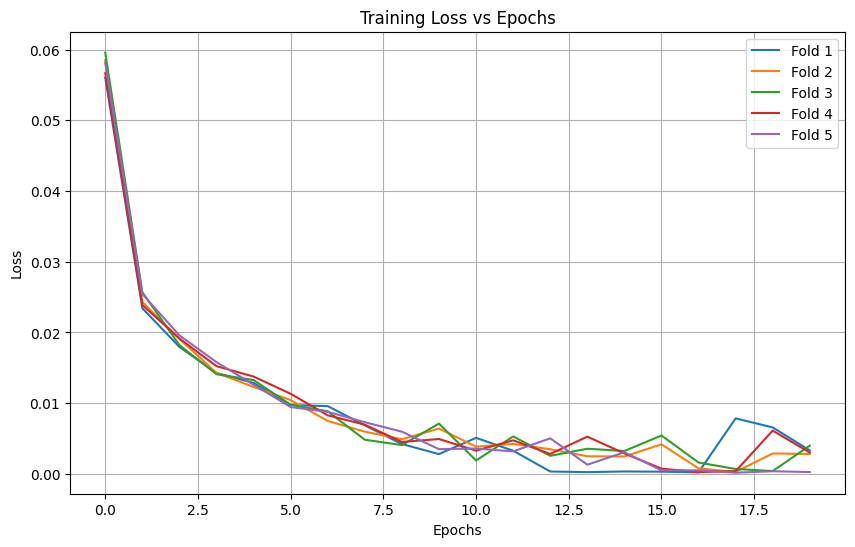

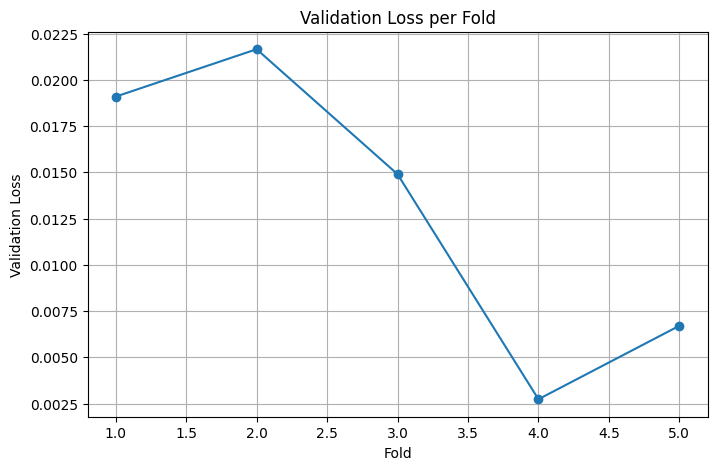

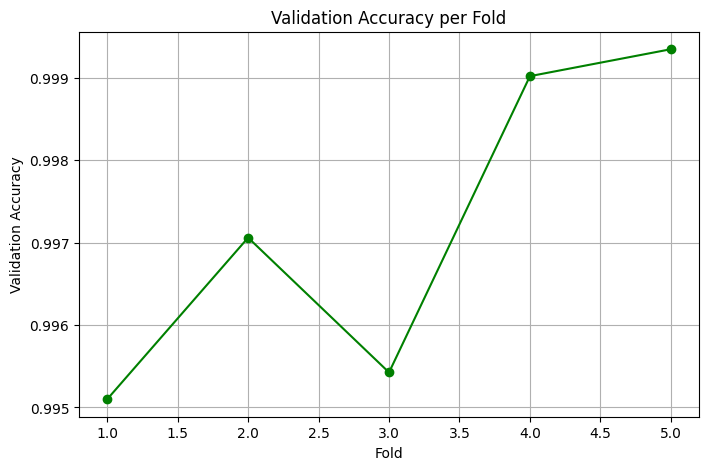

In [ ]:
# Training Loss vs Epochs (for each fold)
plt.figure(figsize=(10, 6))
for i, history in enumerate(all_histories):
    plt.plot(history['loss'], label=f'Fold {i+1}')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#Validation Loss vs Folds
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), val_loss_per_fold, marker='o')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

#Validation Accuracy vs Folds
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), val_acc_per_fold, marker='o', color='green')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

Our validation loss and accuracies are in a fairly consistent range, and the variations can be attributed to the mild variations in test data folds. Overall, the small range of accuracies and standard deviation (shown below) demonstrate the robustness of our model

## Class wise metrics

We now print the class-wise precision, recall, f1score, accuracy, and standard deviation

In [ ]:
classes = label_encoder.classes_
precision_per_class = {cls: [] for cls in classes}
recall_per_class = {cls: [] for cls in classes}
f1_per_class = {cls: [] for cls in classes}

for report in all_reports:
    for cls in classes:
        precision_per_class[cls].append(report[cls]['precision'])
        recall_per_class[cls].append(report[cls]['recall'])
        f1_per_class[cls].append(report[cls]['f1-score'])

print("\nClass-wise Metrics (Average ± Std Dev):")
for cls in classes:
    print(f"{cls}:")
    print(f"  Precision: {np.mean(precision_per_class[cls]):.3f} ± {np.std(precision_per_class[cls]):.3f}")
    print(f"  Recall:    {np.mean(recall_per_class[cls]):.3f} ± {np.std(recall_per_class[cls]):.3f}")
    print(f"  F1 Score:  {np.mean(f1_per_class[cls]):.3f} ± {np.std(f1_per_class[cls]):.3f}")


Class-wise Metrics (Average ± Std Dev):
0.0:
  Precision: 0.999 ± 0.001
  Recall:    0.997 ± 0.002
  F1 Score:  0.998 ± 0.001
1.0:
  Precision: 0.984 ± 0.013
  Recall:    0.994 ± 0.005
  F1 Score:  0.989 ± 0.008
3.0:
  Precision: 0.995 ± 0.004
  Recall:    1.000 ± 0.000
  F1 Score:  0.997 ± 0.002


### Confusion Matrix

Here we show the mean confusion matrix across all folds

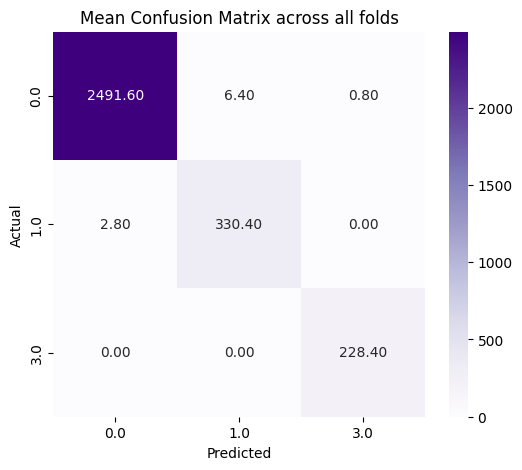

In [23]:
mean_cm = np.mean(confusion_matrices, axis=0)

plt.figure(figsize=(6, 5))
sns.heatmap(mean_cm, annot=True, fmt='.2f', cmap='Purples',
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Mean Confusion Matrix across all folds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Average Accuracy / F-1 scores and standard deviation

In [26]:
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"Mean Accuracy across all folds: {mean_acc:.4f}")
print(f"Standard Deviation of Accuracy: {std_acc:.4f}")

Mean Accuracy across all folds: 0.9967
Standard Deviation of Accuracy: 0.0018


In [27]:
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"Mean F1 Macro Score across all folds: {mean_f1:.4f}")
print(f"Standard Deviation of F1 Scores: {std_f1:.4f}")


Mean F1 Macro Score across all folds: 0.9942
Standard Deviation of F1 Scores: 0.0031


# **Evaluation Function**

In [31]:
import pickle
def evaluate_model(checkpoint_paths, test_data_paths):
    accuracies = []
    f1_scores = []
    fold_no = 1

    for ckpt, test_data_file in zip(checkpoint_paths, test_data_paths):
        print(f"\n--- Evaluating Fold {fold_no} ---")

        # Load test data
        with open(test_data_file, 'rb') as f:
            X_test, meta_test, y_test = pickle.load(f)

        # Create model and load weights
        model = create_model()
        model.load_weights(ckpt)

        # Predict and evaluate
        y_pred = model.predict([X_test, meta_test])
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)

        acc = accuracy_score(y_true_classes, y_pred_classes)
        f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

        print(f"Fold {fold_no} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

        accuracies.append(acc)
        f1_scores.append(f1)

        fold_no += 1

    return np.mean(accuracies)


## Calling the evaluate function

In [33]:
checkpoint_paths = [f"Trained_Model_Fold{i}.weights.h5" for i in range(1, 6)]
test_data_paths = [f"test_data_fold{i}.pkl" for i in range(1, 6)]

accuracy = evaluate_model(checkpoint_paths, test_data_paths)
print(f"\nAccuracy across all folds: {accuracy:.4f}")



--- Evaluating Fold 1 ---


c:\Users\Admin\anaconda3\envs\dlproject\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Fold 1 - Accuracy: 0.9954, F1 Score: 0.9918

--- Evaluating Fold 2 ---


c:\Users\Admin\anaconda3\envs\dlproject\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Fold 2 - Accuracy: 0.9941, F1 Score: 0.9902

--- Evaluating Fold 3 ---


c:\Users\Admin\anaconda3\envs\dlproject\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Fold 3 - Accuracy: 0.9993, F1 Score: 0.9989

--- Evaluating Fold 4 ---


c:\Users\Admin\anaconda3\envs\dlproject\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Fold 4 - Accuracy: 0.9980, F1 Score: 0.9965

--- Evaluating Fold 5 ---


c:\Users\Admin\anaconda3\envs\dlproject\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Fold 5 - Accuracy: 0.9967, F1 Score: 0.9938

Accuracy across all folds: 0.9967


# Other Tested Model(s) - Results and Drawbacks  --- Ablation Study

### Here, we domenstrate ablation studies for all the models we tried

#### LSTM 

| Sr No | Version                                                       | Epochs | Accuracy | Macro F1 Score |
|-------|---------------------------------------------------------------|--------|----------|----------------|
| 1     | Weighted CE loss + normalization                              | 20     | 0.9630   | 0.9060         |
| 2     | Normalization + Oversampling                                  | 20     | 0.9650   | 0.9039         |
| 3     | lstm + normalising +gaussian noise/flipping 	                | 50	 | 0.9	    | 0.89           |   
| 4     | Oversampling + Normalization + Extra PIR                      | 20     | 0.9552   | 0.9349         |
| 5     | Metadata + Oversampling + Normalization + Extra PIR           | 20     | 0.9790   | 0.9680         |
| **6** | **Weighted CE + Normalization + Extra PIR** | **20** | **0.9800** | **0.9662** |
| 7     | Metadata + Weighted CE + Normalization + Extra PIR            | 20     | 0.9700   | 0.9500         |


Weighted Loss or Oversampling(using RandomOverSampler module) on Original 55 PIR values gave almost same metrics whereas augmenting the dataset using Gaussian Noise and time flip for minority classes may have introduced more noise leading to reduced metric values. 
Using extra PIR features along with Meta data significantly increased the performance by the LSTM model.

#### Transformer (4 Attention Heads, 9 Layers)

| Sr No | Version                                                        | Epochs | Accuracy | Macro F1 Score |
|-------|----------------------------------------------------------------|--------|----------|----------------|
| 1     | Weighted loss                                                  | 8      | 0.8461   | 0.8274         |
| 2     | Weighted loss + extra PIR (total 109)                          | 8      | 0.8527   | 0.8334         |
| 3     | Weighted loss + oversampling                                   | 8      | 0.8445   | 0.8270         |
| 4     | Oversampling                                                   | 8      | 0.9771   | 0.9641         |
| 5     | SMOTE                                                          | 8      | 0.9510   | 0.9193         |
| 6     | Oversampling + extra PIR                                       | 8      | 0.9794   | 0.9671         |
| 7     | Oversampling + extra PIR                                       | 20     | 0.9762   | 0.9628         |
| **8**     | **Oversampling + extra PIR + 8 heads**                             | **8**      | **0.9876**   | **0.9795**         |
| 9     | Oversampling + extra PIR + 8 heads + 12 encoder layers         | 8      | ~0.9200  | ~0.9200        |
| 10    | Oversampling + extra PIR + 8 heads + 12 encoder layers         | 20     | 0.9837   | 0.9739         |
| 11    | Normalizing + 8 heads                                          | 50     | 0.9402   | 0.9155         |


As we can see from the ablation scoes, methods that mitigate the effects of data skewness boost the model performance. For exmaple. both oversampling and SMOTE give significantly more accuacy as compared to weighted loss. Adding extra PIR values (55 to 109) also has a positive effect on the model.

The best accuracy was given by oversampling and adding extra PIR values to the fundamental data

#### CNN-BLSTM

| Sr No | Version                                      | Epochs | Accuracy     | Macro F1 Score |
|-------|----------------------------------------------|--------|--------------|----------------|
| 1     | Normalization                                | 20     | 0.9884       | 0.9611         |
| 2     | Normalization + Oversampling                 | 20     | 0.9920       | 0.9753         |
| 3     | Normalization + Extra PIR Values             | 20     | 0.9957       | 0.9933         |
| **4** | **Normalization + Extra PIR + Oversampling** | **20** | **0.9967** | **0.9942** |


Similar to the previosu observations, here also we observe a boost in accuracy when we oversample data, and add extra PIR values. Note that the best accuracy and f1 scores are given when both of these are used together.